<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/q_finance/quantum_amplitude_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install qiskit-aer
!pip install qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: file

In [2]:
p = 0.2

In [3]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [4]:
A = BernoulliA(p)
Q = BernoulliQ(p)

In [5]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

<ipython-input-5-254369b6a41a>:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms import EstimationProblem


In [6]:
from qiskit.primitives import Sampler

sampler = Sampler()

### Canonical AE

In [7]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)

In [8]:
ae_result = ae.estimate(problem)

In [9]:
print(ae_result.estimation)

0.1464466


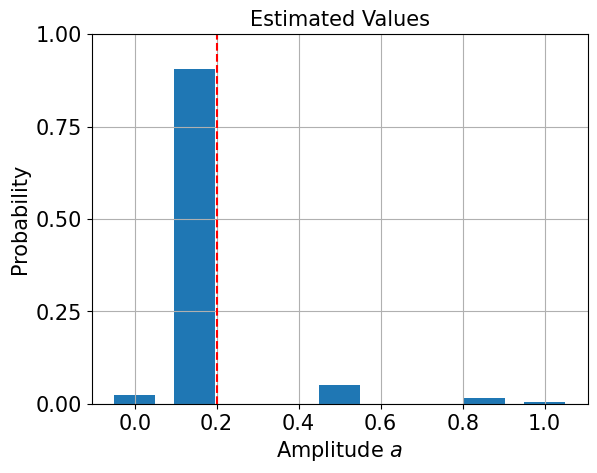

In [10]:
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [11]:
print("Interpolated MLE estimator:", ae_result.mle)

Interpolated MLE estimator: 0.19999999403255486


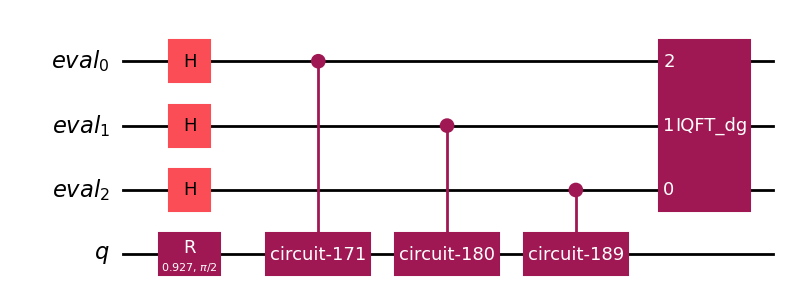

In [12]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl", style="iqx"
)  # decompose 1 level: exposes the Phase estimation circuit!

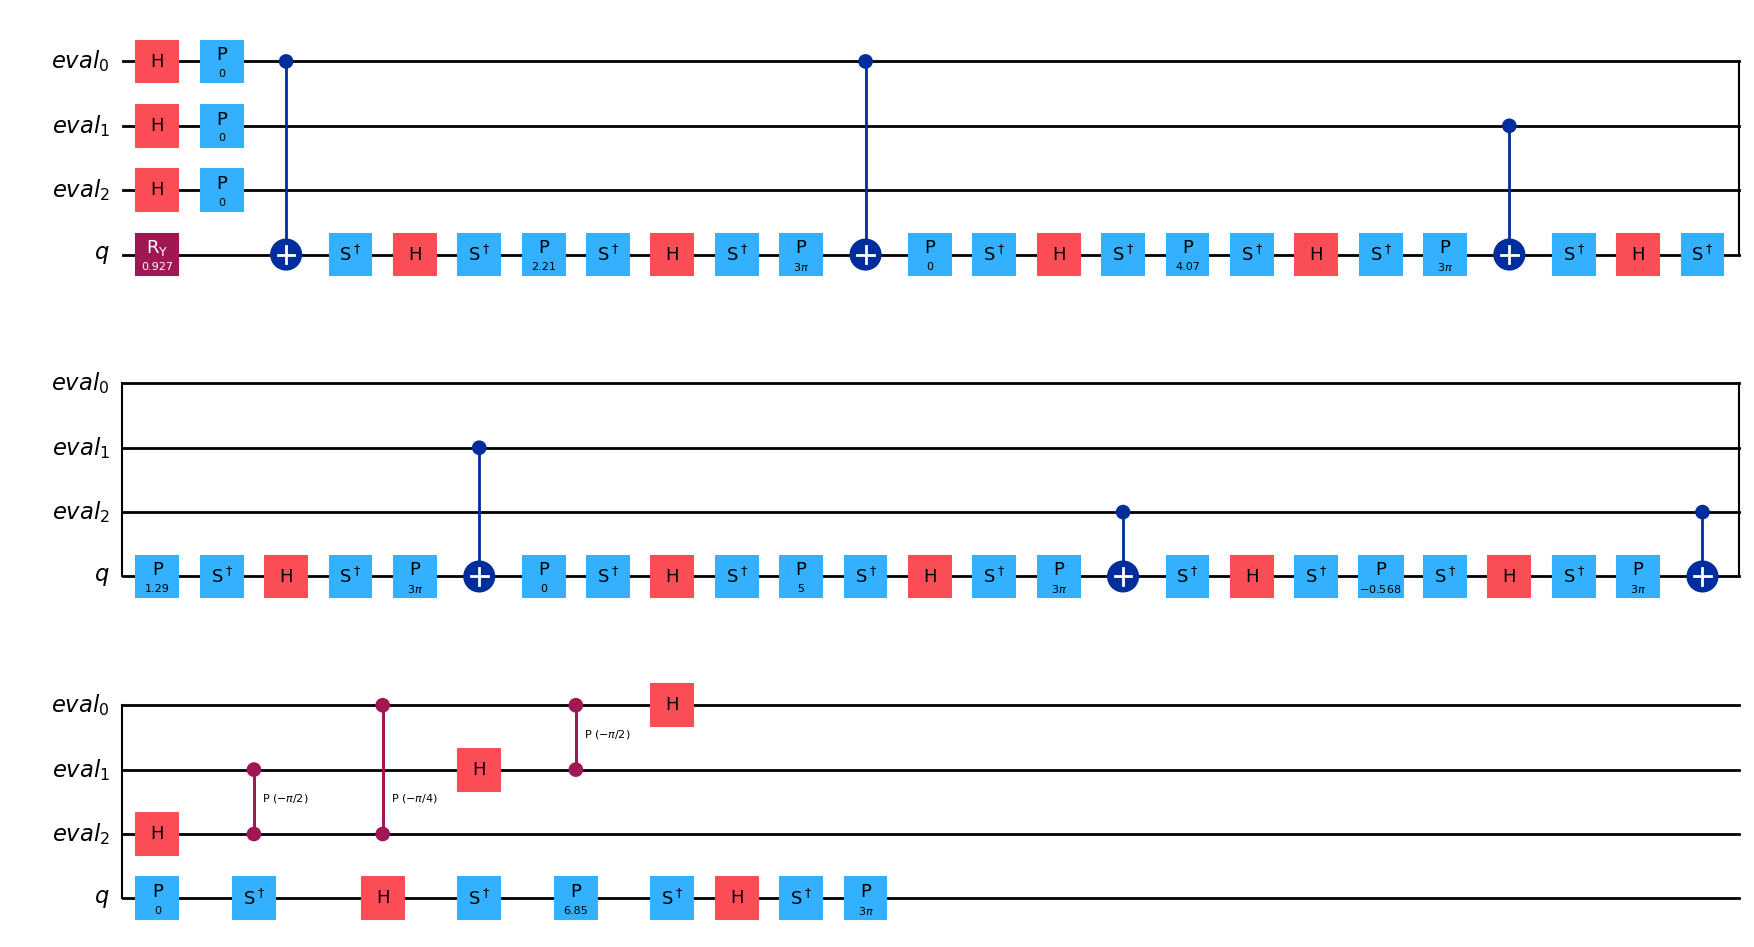

In [13]:
from qiskit import transpile


basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")

### Iterative Amplitude Estimation

In [14]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.2


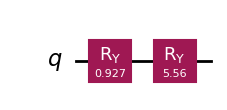

In [15]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw("mpl", style="iqx")

### Maximum Likelihood Amplitude Estimation

In [16]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,  # log2 of the maximal Grover power
    sampler=sampler,
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.20002237175368104


### Faster Amplitude Estimation

In [17]:
from qiskit.algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    sampler=sampler,
)
fae_result = fae.estimate(problem)

print("Estimate:", fae_result.estimation)

/usr/local/lib/python3.10/dist-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:209: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


Estimate: 0.1991127182379733
